# Evaluation on Kang Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib
%matplotlib inline

# Do not show FutureWarnings
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
import os
import pandas as pd
import anndata as ad
import numpy as np
import benchmark as bm
import plotnine as p9
from prismo import PRISMO
from prismo import FeatureSets as fs
from scarches.models import EXPIMAP
import pickle

# Settings
device = "cuda:1"
seed = 3141
rng = np.random.default_rng(seed)

import sys

sys.path.append("..")
from plotting_settings import discrete_scale_fill, discrete_scale_color

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Spectra GPU support is still under development. Raise any issues on github 
 
 Changes from v1: 
 (1) GPU support [see tutorial] 
 (2) minibatching for local parameters and data 
 Note that minibatching may affect optimization results 
 Code will eventually be merged into spectra.py
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# Test Parameters
FPR = 0.2
database = "RH"
version = "v1-3000"

LOAD_EXPIMAP = True
LOAD_SPECTRA = True
LOAD_PRISMO = True

## Load data and Reactome pathways

### Preprocessing

In [4]:
adata, true_mask, noisy_mask, terms, true_mask_copy = bm.get_data(
    FPR, FPR, database=database, version=version, seed=seed, rng=rng
)
data_dict = bm.preprocess(adata)

INFO:prismo._core.feature_sets:Found 16 pairs to merge.
INFO:prismo._core.feature_sets:Found 3 pairs to merge.
INFO:prismo._core.feature_sets:Found 2 pairs to merge.
INFO:prismo._core.feature_sets:Found 0 pairs to merge. Stopping...


<FeatureSets 'h.all.v7.5.1.symbols.gmt' with 13 feature sets>
<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 73 feature sets>
<FeatureSets 'h.all.v7.5.1.symbols.gmt|c2.cp.reactome.v7.5.1.symbols.gmt' with 65 feature sets>


# Split adata into train and test
n_samples = adata.shape[0]
n_train = int(0.90 * n_samples)
n_test = n_samples - n_train
train_idx = rng.choice(n_samples, n_train, replace=False)
test_idx = np.setdiff1d(np.arange(n_samples), train_idx)

train_data = {k: v[train_idx] for k, v in data_dict.items()}
test_data = {k: v[test_idx] for k, v in data_dict.items()}

adata_train = adata[train_idx].copy()
adata_test = adata[test_idx].copy()

adata = adata_train

# Train all Models

In [5]:
model_dict = {}

### Train Expimap

In [6]:
soft_mask = True
recon_loss = "mse"
model_name = f"./models/expimap_{database}_{FPR}_{version}_{seed}"

if LOAD_EXPIMAP & os.path.exists(model_name):
    print("Loading model")
    adata = ad.AnnData(data_dict["expimap"])
    adata.obs["cond"] = "cond"
    adata.varm["I"] = noisy_mask.T
    adata.uns["terms"] = terms
    model_dict["expimap"] = EXPIMAP.load(model_name, adata=adata)
else:
    print("Training model")
    model_dict["expimap"] = bm.train_expimap(
        data_dict["expimap"],
        noisy_mask,
        seed=seed,
        terms=terms,
        recon_loss=recon_loss,
        n_epochs=1000,
        batch_size=1000,
        soft_mask=soft_mask,
        hidden_size_1=512,
        hidden_size_2=256,
    )
    model_dict["expimap"].save(model_name)

Loading model
AnnData object with n_obs × n_vars = 13576 × 3000
    obs: 'cond'
    uns: 'terms'
    varm: 'I'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 65
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  65 0 0 1 3000
	with soft mask.
Last Decoder layer: identity


### Train Sepctra

In [7]:
model_name = f"./models/spectra_{database}_{FPR}_{version}_{seed}"

if LOAD_SPECTRA & os.path.exists(f"{model_name}.pkl"):
    with open(f"{model_name}.pkl", "rb") as f:
        model_dict["spectra"] = pickle.load(f)
else:
    model_dict["spectra"] = bm.train_spectra(
        data_dict["spectra"], noisy_mask, terms=terms, num_epochs=10000
    )

    # Save the model
    with open(f"{model_name}.pkl", "wb") as f:
        pickle.dump(model_dict["spectra"], f)

### Train PRISMO

In [8]:
for model_name_parmams in [
    f"prismo_0.003_200_5000_0.005_2_0.1_{database}_{FPR}_{version}_{seed}",
]:
    for model_name in ["prismo", "prismo_nmf"]:
        if "nmf" in model_name:
            model_name_parmams = model_name_parmams.replace("prismo", "prismo_nmf")

        def extract_params_from_string(s):
            if "nmf" in s:
                s = s.replace("_nmf", "")
            (
                lr,
                early_stopper_patience,
                max_epochs,
                prior_penalty,
                n_factors,
                dense_factor_scale,
                *rest,
            ) = s.split("_")[1:]
            return (
                lr,
                early_stopper_patience,
                max_epochs,
                prior_penalty,
                n_factors,
                dense_factor_scale,
            )

        (
            lr,
            early_stopper_patience,
            max_epochs,
            prior_penalty,
            n_factors,
            dense_factor_scale,
        ) = extract_params_from_string(model_name_parmams)

        if LOAD_PRISMO & os.path.exists(f"./models/{model_name_parmams}.h5"):
            print(f"Loading Model {model_name_parmams}")
            model_dict[model_name] = PRISMO.load(f"./models/{model_name_parmams}.h5")
        else:
            print("Training Model")
            model_dict[model_name] = bm.train_prismo(
                data_dict[model_name],
                noisy_mask,
                obs=adata.obs,
                var=adata.var,
                seed=seed,
                terms=terms,
                obs_names=adata.obs_names.copy(),
                var_names=adata.var_names.copy(),
                n_factors=n_factors,
                nmf="nmf" in model_name,
                prior_penalty=prior_penalty,
                max_epochs=max_epochs,
                batch_size=0,
                n_particles=1,
                lr=lr,
                early_stopper_patience=early_stopper_patience,
                device=device,
                true_mask=true_mask,
                init_factors="random",
                init_scale=0.1,
                save_path=f"./models/{model_name_parmams}.h5",
                dense_factor_scale=dense_factor_scale,
            )

Loading Model prismo_0.003_200_5000_0.005_2_0.1_RH_0.2_v1-3000_3141
Loading Model prismo_nmf_0.003_200_5000_0.005_2_0.1_RH_0.2_v1-3000_3141


In [9]:
model = model_dict["prismo"]
model_dict = {
    "expimap": model_dict["expimap"],
    "spectra": model_dict["spectra"],
    "prismo": model_dict["prismo"],
    "prismo_nmf": model_dict["prismo_nmf"],
}

### Compute Metrics

In [10]:
df_scores = pd.DataFrame(columns=["model", "score", "metric"])

# AUPRC
top = 200
for model_name, model in model_dict.items():
    scores = bm.get_average_precision(true_mask, model, per_factor=True, top=top)
    prec, rec, f1, _ = bm.get_binary_scores(
        true_mask, model, threshold=None, per_factor=True, top=top, verbose=False
    )
    rmse = bm.get_rmse(model, data_dict[model_name])
    _, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    non_zero = np.abs(wh) > 0.0
    tp = (tm & nm & non_zero).sum(axis=1).tolist()
    tn = (~tm & ~nm & non_zero).sum(axis=1).tolist()
    fp = (~tm & nm & non_zero).sum(axis=1).tolist()  # FIXME
    fn = (tm & ~nm & non_zero).sum(axis=1).tolist()  # FIXME

    df_scores = pd.concat(
        [
            df_scores,
            pd.DataFrame({"model": model_name, "score": scores, "metric": "aupr"}),
            pd.DataFrame({"model": model_name, "score": prec, "metric": "precision"}),
            pd.DataFrame({"model": model_name, "score": rec, "metric": "recall"}),
            pd.DataFrame({"model": model_name, "score": f1, "metric": "f1"}),
            pd.DataFrame(
                {"model": model_name, "score": rmse, "metric": "rmse"}, index=[0]
            ),
            pd.DataFrame({"model": model_name, "score": tp, "metric": "tp"}),
            pd.DataFrame({"model": model_name, "score": tn, "metric": "tn"}),
            pd.DataFrame({"model": model_name, "score": fp, "metric": "fp"}),
            pd.DataFrame({"model": model_name, "score": fn, "metric": "fn"}),
        ]
    )

# Make model column categorical
df_scores["model"] = pd.Categorical(
    df_scores["model"], categories=["expimap", "spectra", "prismo", "prismo_nmf"]
)

(65, 3000)
(65, 3000)
(65, 3000)
(65, 3000)


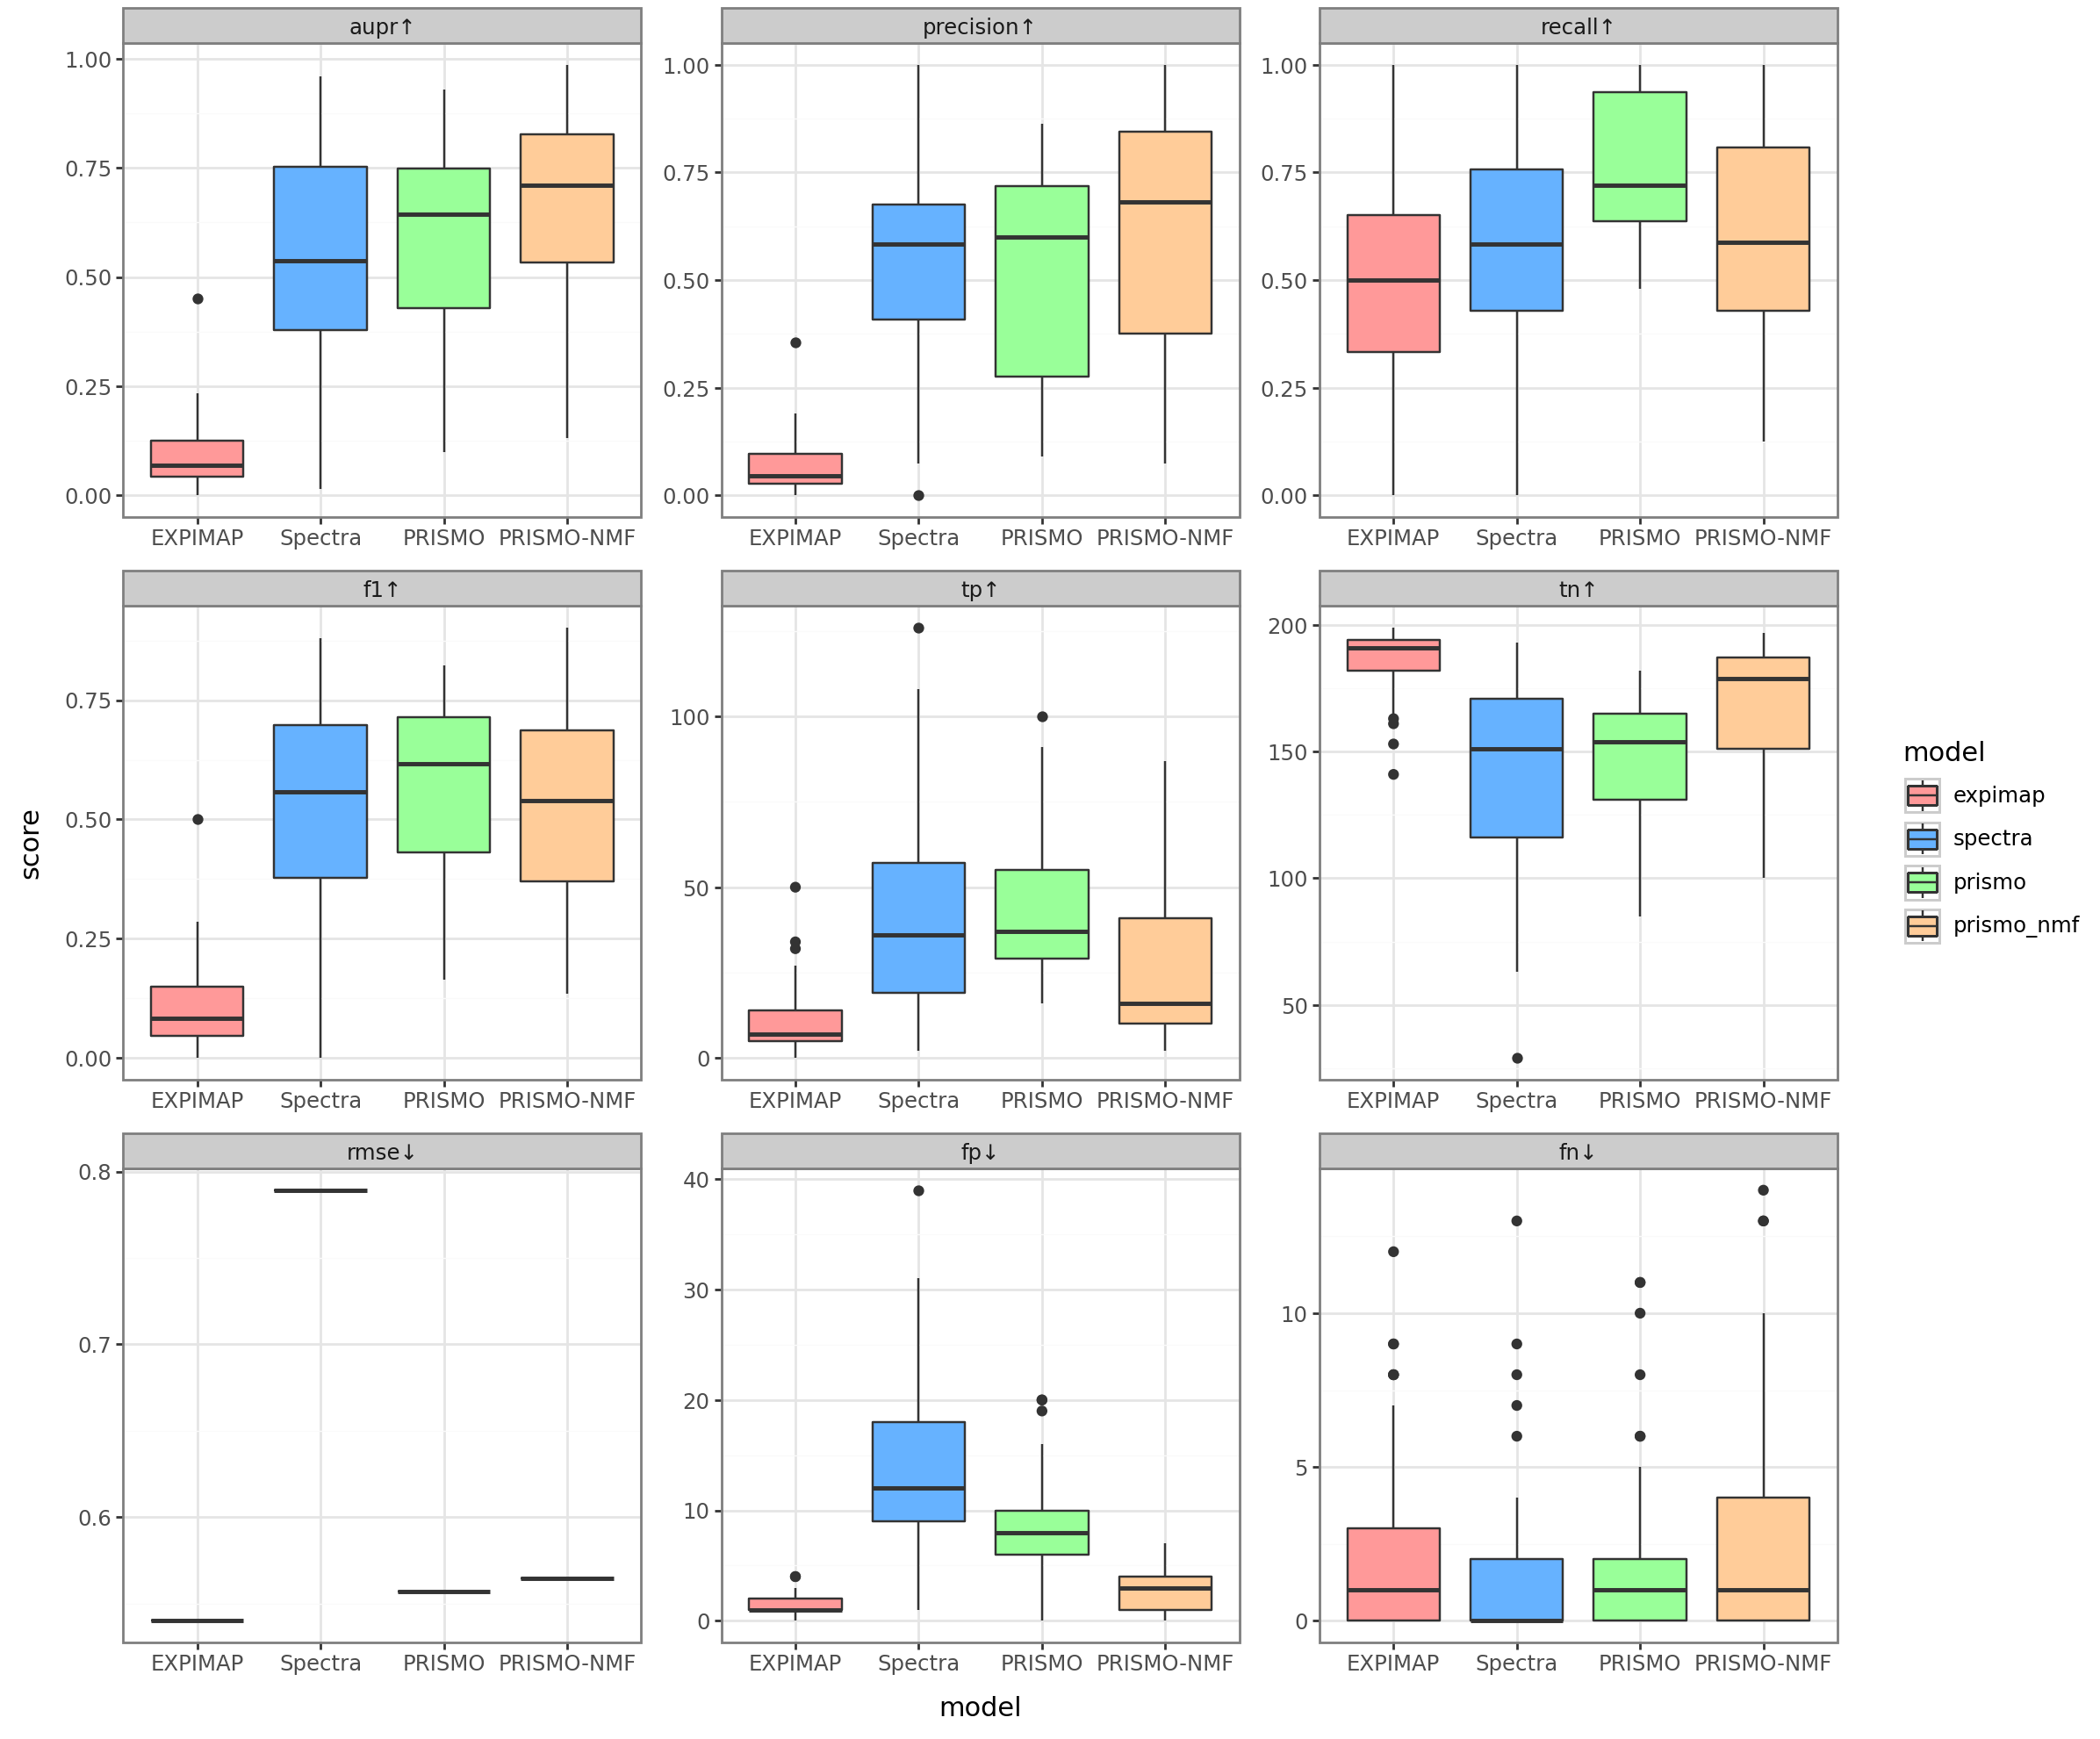

In [19]:
model_labels = ["EXPIMAP", "Spectra", "PRISMO", "PRISMO-NMF"]
df_plot = df_scores.copy()
# Append "↓" to the metric names except for "fn" and "fp" where we add a "↑"
df_plot["metric"] = df_plot.apply(
    lambda x: x["metric"] + ("↓" if x["metric"] in ["fn", "fp", "rmse"] else "↑"),
    axis=1,
)
df_plot["metric"] = pd.Categorical(
    df_plot["metric"],
    categories=[
        "aupr↑",
        "precision↑",
        "recall↑",
        "f1↑",
        "tp↑",
        "tn↑",
        "rmse↓",
        "fp↓",
        "fn↓",
    ],
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(12, 10))
    + p9.facet_wrap("~metric", scales="free")
    + discrete_scale_fill
)
if model_labels is not None:
    p = p + p9.scale_x_discrete(labels=model_labels)
p.show()

In [22]:
df_plot.groupby(["metric", "model"]).mean()

score
metric     model                 
aupr↑      expimap       0.088862
           spectra       0.540098
           prismo        0.599033
           prismo_nmf    0.663256
precision↑ expimap       0.068240
           spectra       0.546779
           prismo        0.515696
           prismo_nmf    0.606985
recall↑    expimap       0.508184
           spectra       0.582838
           prismo        0.762957
           prismo_nmf    0.594330
f1↑        expimap       0.110921
           spectra       0.522710
           prismo        0.556420
           prismo_nmf    0.534015
tp↑        expimap      10.415385
           spectra      42.430769
           prismo       43.169231
           prismo_nmf   26.184615
tn↑        expimap     186.138462
           spectra     142.507692
           prismo      146.723077
           prismo_nmf  168.415385
rmse↓      expimap       0.539989
           spectra       0.789181
           prismo        0.556891
           prismo_nmf    0.564472
fp↓        expimap       1.169231
           spectra      13.753846
           prismo        8.523077
           prismo_nmf    2.676923
fn↓        expimap       2.276923
           spectra       1.307692
           prismo        1.584615
           prismo_nmf    2.723077

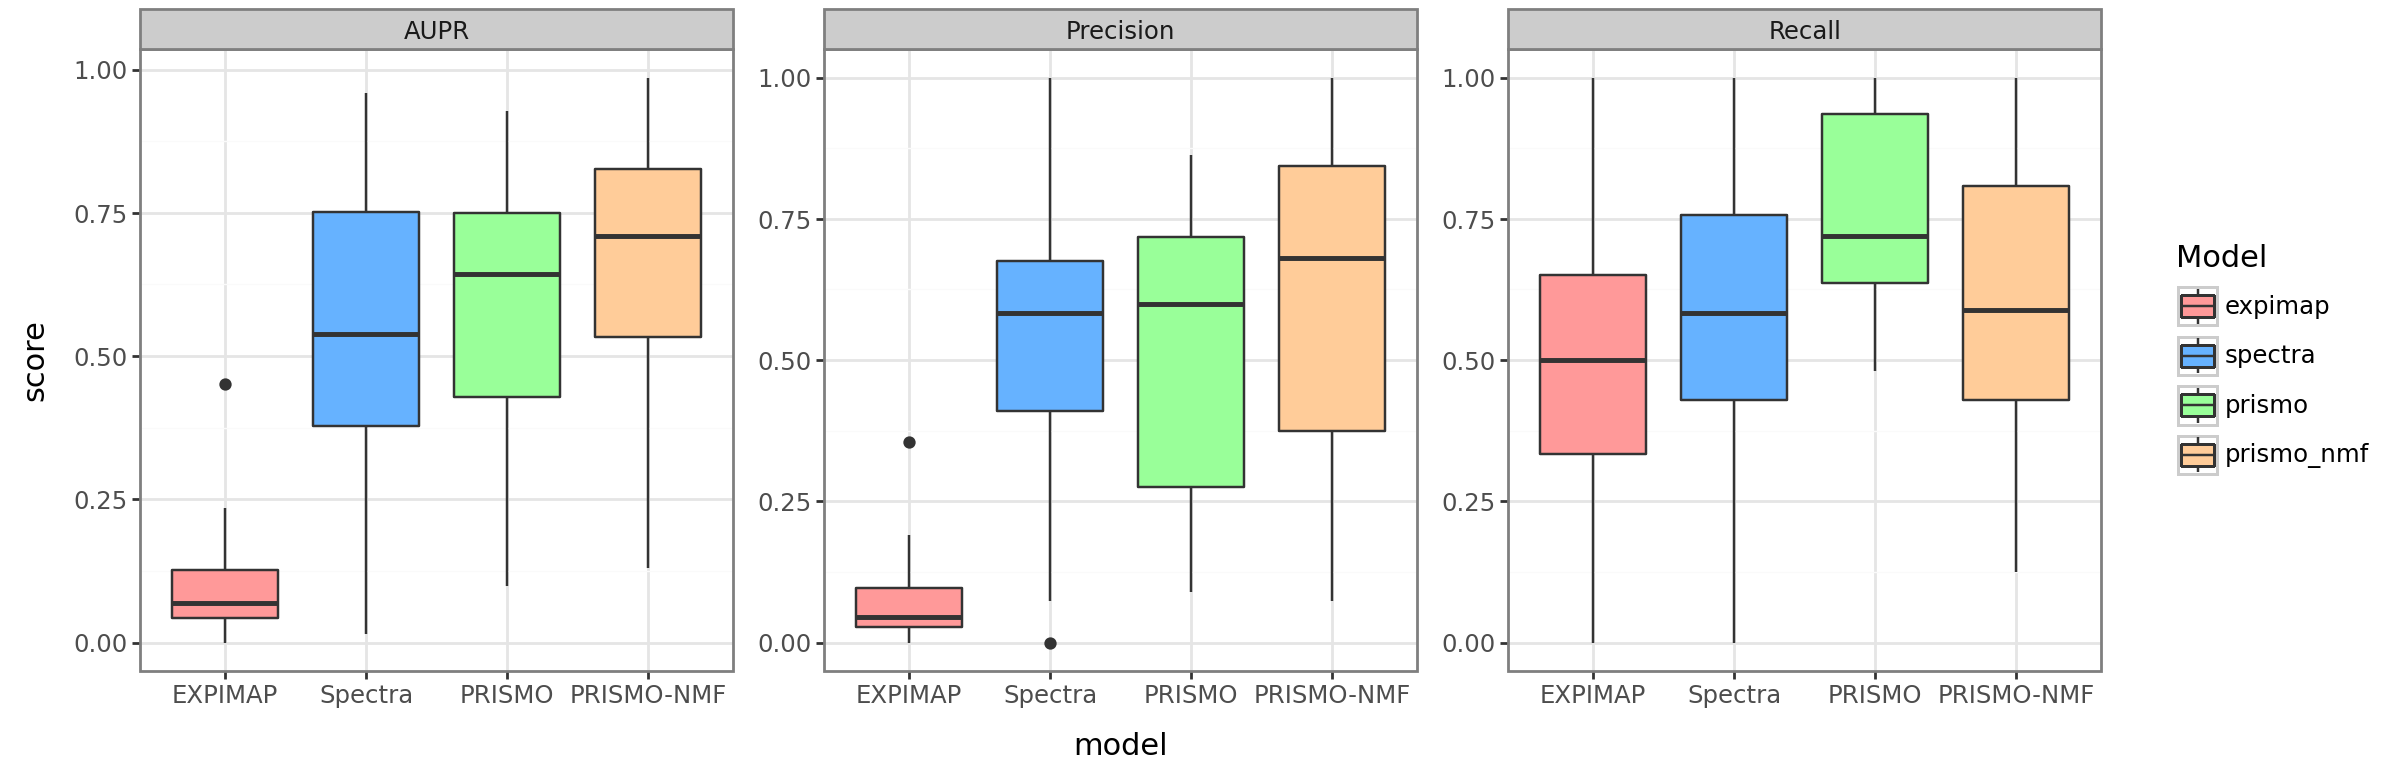

In [13]:
model_labels = ["EXPIMAP", "Spectra", "PRISMO", "PRISMO-NMF"]
df_plot = df_scores.copy()
# Append "↓" to the metric names except for "fn" and "fp" where we add a "↑"
df_plot["metric"] = df_plot.apply(
    lambda x: x["metric"] + ("↓" if x["metric"] in ["fn", "fp", "rmse"] else "↑"),
    axis=1,
)
df_plot["metric"] = pd.Categorical(
    df_plot["metric"],
    categories=[
        "aupr↑",
        "precision↑",
        "recall↑",
    ],
)
# Drop all rows with nans
df_plot = df_plot.dropna()
# Rename values
df_plot["metric"] = df_plot["metric"].replace(
    {
        "aupr↑": "AUPR",
        "precision↑": "Precision",
        "recall↑": "Recall",
    }
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(12, 4))
    + p9.facet_wrap("~metric", scales="free")
    + discrete_scale_fill
    # Rename legend title
    + p9.labs(fill="Model")
)
if model_labels is not None:
    p = p + p9.scale_x_discrete(labels=model_labels)
p.show()

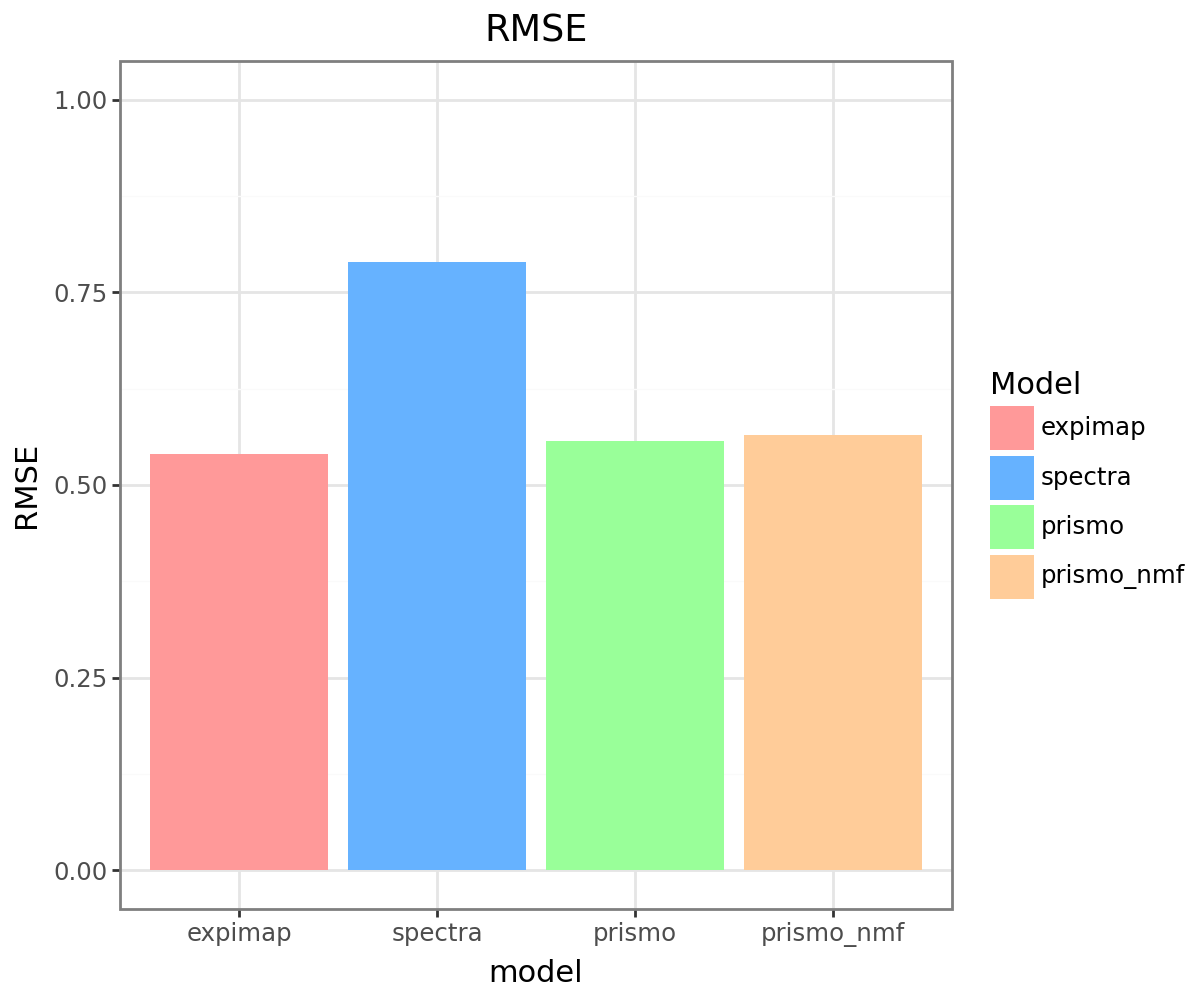

In [14]:
# Make a barplot for the RMSE
df_plot = df_scores[df_scores["metric"] == "rmse"].copy()
df_plot["model"] = pd.Categorical(
    df_plot["model"], categories=["expimap", "spectra", "prismo", "prismo_nmf"]
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_bar(stat="identity")
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(6, 5))
    + p9.coord_cartesian(ylim=(0, 1))
    + discrete_scale_fill
    + p9.ylab("RMSE")
    + p9.labs(fill="Model")
    # Set title
    + p9.ggtitle("RMSE")
)
p

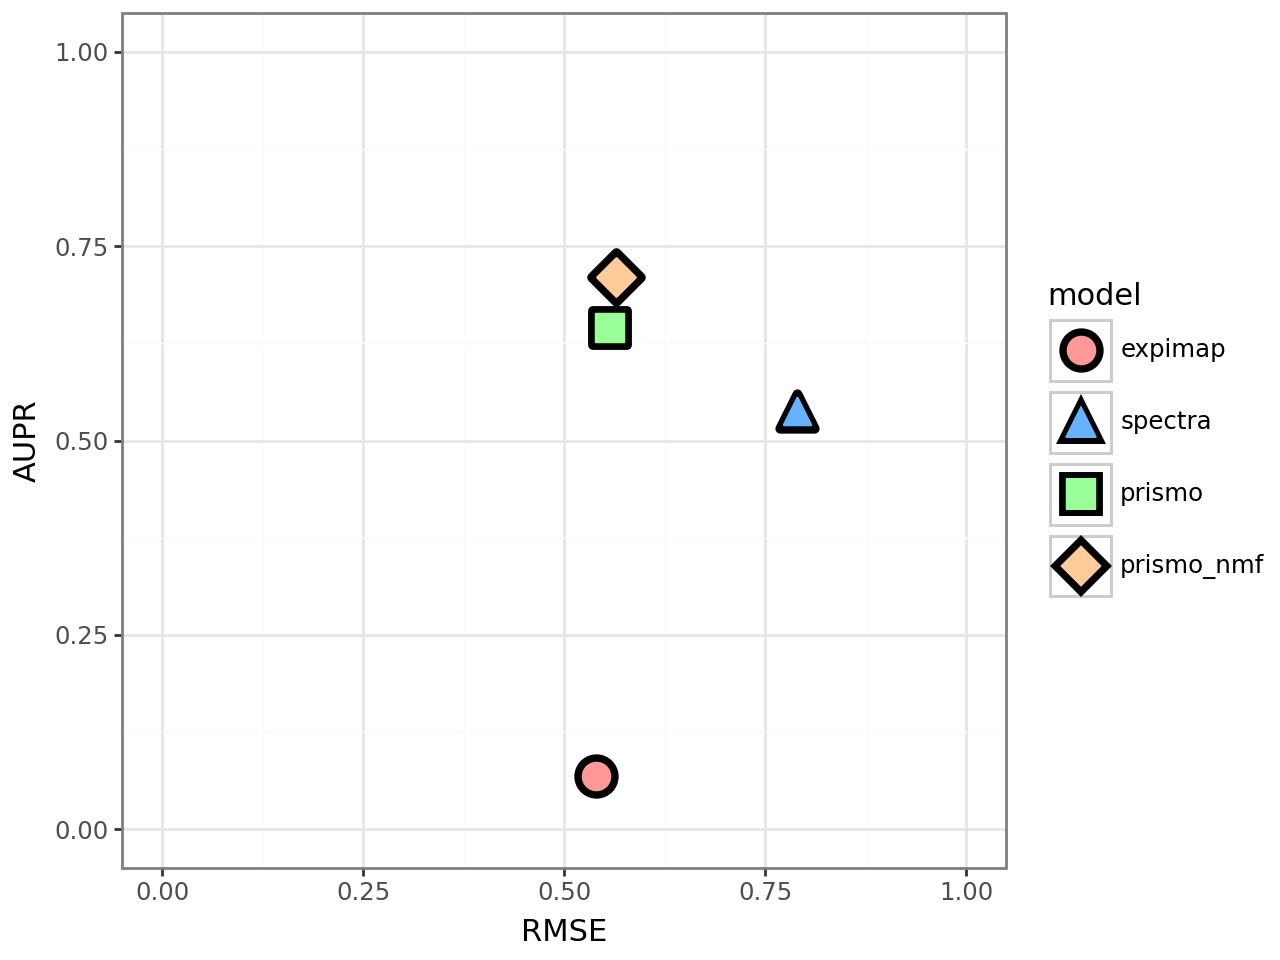

In [15]:
# Make a scatterplot of RMSE vs AUPR from df_scores_grouped
df_scores_grouped = df_scores.groupby(["model", "metric"]).median().reset_index()
df_plot = df_scores_grouped[df_scores_grouped["metric"].isin(["aupr", "rmse"])]
df_plot = df_plot.pivot(index="model", columns="metric", values="score")
df_plot = df_plot.reset_index()

(
    p9.ggplot(
        df_plot.reset_index(), p9.aes(x="rmse", y="aupr", color="model", shape="model")
    )
    + p9.geom_point(size=5, stroke=2, color="black", fill=None)
    + p9.geom_point(size=5)
    + p9.xlim(0.0, 1.0)
    + p9.ylim(0.0, 1.0)
    + p9.theme(legend_position="right")
    + p9.labs(x="RMSE", y="AUPR")
    + discrete_scale_color
)

In [16]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0]
df_noise_scores = pd.DataFrame(columns=["model", "score", "metric", "fpr", "fnr"])

for fnr in noise_levels:
    for fpr in noise_levels:
        print(f"Running {fpr} {fnr}")
        if fpr + fnr > 1.0:
            continue
        adata, true_mask, noisy_mask, terms, true_mask_copy = get_data(fpr, fnr)
        data_dict = preprocess(adata)

        model_name = "expimap"

        if os.path.exists(f"/data/m015k/prismo/benchmark/expimap/expimap_{fpr}_{fnr}"):
            print("Loading model")
            adata = ad.AnnData(data_dict[model_name.split("_")[0]])
            adata.obs["cond"] = "cond"
            adata.varm["I"] = noisy_mask.T
            adata.uns["terms"] = terms
            model = EXPIMAP.load(
                f"/data/m015k/prismo/benchmark/expimap/expimap_{fpr}_{fnr}", adata=adata
            )
        else:
            model = bm.train_expimap(
                data_dict["expimap"],
                noisy_mask,
                seed=seed,
                terms=terms,
                recon_loss="mse",
                n_epochs=1000,
                batch_size=1000,
                soft_mask=True,
                hidden_size_1=512,
                hidden_size_2=256,
            )
            model.save(f"/data/m015k/prismo/benchmark/expimap/expimap_{fpr}_{fnr}")

        # AUPRC
        top = 200
        scores = bm.get_average_precision(true_mask, model, per_factor=True, top=top)
        prec, rec, f1, _ = bm.get_binary_scores(
            true_mask, model, threshold=None, per_factor=True, top=top, verbose=False
        )
        rmse = bm.get_rmse(model, data_dict[model_name])
        _, wh, tm, nm = bm.get_reconstruction_fraction(
            true_mask, noisy_mask, model, top=200
        )
        non_zero = np.abs(wh) > 0.0
        tp = (tm & nm & non_zero).sum(axis=1).tolist()
        tn = (~tm & ~nm & non_zero).sum(axis=1).tolist()
        fp = (~tm & nm & non_zero).sum(axis=1).tolist()
        fn = (tm & ~nm & non_zero).sum(axis=1).tolist()

        df_noise_scores = pd.concat(
            [
                df_noise_scores,
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": scores,
                        "metric": "aupr",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": prec,
                        "metric": "precision",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": rec,
                        "metric": "recall",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": f1,
                        "metric": "f1",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": rmse,
                        "metric": "rmse",
                        "fpr": fpr,
                        "fnr": fnr,
                    },
                    index=[0],
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": tp,
                        "metric": "tp",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": tn,
                        "metric": "tn",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": fp,
                        "metric": "fp",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
                pd.DataFrame(
                    {
                        "model": model_name,
                        "score": fn,
                        "metric": "fn",
                        "fpr": fpr,
                        "fnr": fnr,
                    }
                ),
            ]
        )

Running 0.0 0.0


NameError: name 'get_data' is not defined

In [ ]:
df_plot = df_noise_scores.loc[df_noise_scores["metric"] == "rmse"]
# df_plot["fpr"] = pd.Categorical(df_plot["fpr"])
df_plot["fpr"] = df_plot["fpr"].astype(str)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="fpr", y="score", fill="fnr"),
    )
    + p9.geom_boxplot()
    + p9.facet_wrap("~fnr", scales="free", ncol=10)
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(20, 5))
)
p

In [ ]:
model_dict = {}
model_perf = {}

# Compute losses for different noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for noise in noise_levels:
    model_perf[noise] = {}

    adata = ad.read_h5ad("data/kang_tutorial.h5ad").copy()
    adata.var_names = adata.var_names.str.upper()
    adata._inplace_subset_var(adata.to_df().std() > 0.2)

    gene_set_collection = fs.from_gmt("../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt")
    gene_set_collection = gene_set_collection.filter(
        adata.var_names,
        min_fraction=0.4,
        min_count=40,
        max_count=200,
    )
    true_mask = gene_set_collection.to_mask(adata.var_names.tolist())
    terms = true_mask.index.tolist()

    # Modify the prior knowledge introducing noise
    true_mask_copy = true_mask.copy()
    true_mask = true_mask.values
    noisy_mask = bm.get_rand_noisy_mask(rng, true_mask, fpr=noise, fnr=noise)

    x = adata.X
    x = x - x.min(axis=0)
    log_x = np.log1p(x)
    log_x = log_x / log_x.std()
    log_x_centered = log_x - log_x.mean(axis=0)
    log_x_stdised = log_x_centered / log_x_centered.std()

    data_dict = {
        "expimap": log_x_centered.astype(np.float32),
        "expimap_nb": x.astype(np.float32),
        "expimap_hardmask": log_x_centered.astype(np.float32),
        "expimap_hardmask_nb": x.astype(np.float32),
        "spectra": log_x.astype(np.float32),
        "prismo": log_x_centered.astype(np.float32),
        "prismo_nmf": log_x.astype(np.float32),
    }

    for model_name in ["prismo", "prismo_nmf"]:
        if "prismo" in model_name:
            lr = 0.001
            early_stopper_patience = 200
            max_epochs = 1000
            prior_penalty = 0.005
            n_factors = 3
            gamma_prior_scale = 1e-10
            init_scale = 0.1
            model_name_parmams = f"{model_name}_{lr}_{early_stopper_patience}_{max_epochs}_{prior_penalty}_{n_factors}_{gamma_prior_scale}_{init_scale}_{noise}"

            if os.path.exists(f"{model_name_parmams}.h5"):
                model_dict[model_name] = PRISMO.load(f"{model_name_parmams}.h5")
            else:
                model_dict[model_name] = bm.train_prismo(
                    data_dict[model_name],
                    noisy_mask,
                    obs=adata.obs,
                    var=adata.var,
                    seed=seed,
                    terms=terms,
                    obs_names=adata.obs_names.copy(),
                    var_names=adata.var_names.copy(),
                    n_factors=n_factors,
                    nmf="nmf" in model_name,
                    prior_penalty=prior_penalty,
                    max_epochs=max_epochs,
                    batch_size=0,
                    n_particles=1,
                    lr=lr,
                    early_stopper_patience=early_stopper_patience,
                    device="cuda:1",
                    true_mask=true_mask,
                    init_factors="random",
                    init_scale=0.1,
                    save_path=model_name_parmams,
                    dense_factor_scale=init_scale,
                    gamma_prior_scale=gamma_prior_scale,
                )
                model_perf[noise][model_name] = bm.get_average_precision(
                    true_mask, model_dict[model_name], per_factor=False, top=200
                )

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(model_perf).T
df["noise"] = df.index

# Plot using plotnine
df_long = df.melt(var_name="Model", value_name="AUC-PR", id_vars="noise")

p = (
    p9.ggplot(df_long, p9.aes(x="noise", y="AUC-PR", color="Model"))
    + p9.geom_line()
    + p9.geom_point()
    + p9.theme(legend_position="right")
)
p